In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 6.5 MB/s eta 0:00:00

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from darts import TimeSeries
from darts.models import TCNModel

# Function to load data
def load_data(train_file, val_file):
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    
    # Convert 'DateTime' column to datetime and set as index
    for df in [train_df, val_df]:
        df['DateTime'] = pd.to_datetime(df['DateTime'], format="%d-%m-%Y %H:%M")  # Specify the correct format
        df.set_index('DateTime', inplace=True)
    
    return train_df, val_df

# Load CSV data files (adjust paths as needed)
train_file = '/kaggle/input/dataset/train_transformed_10 (1).csv'
val_file = '/kaggle/input/dataset/val_transformed_10.csv'
train_df, val_df = load_data(train_file, val_file)

# Select features and target
features = ['Month', 'Hour','SoilTemp_40cm', 'NET_Radiation', 'SoilTemp_20cm','SoilTemp_80cm']
target = 'SoilTemp_10cm'

X_train = train_df[features].values
y_train = train_df[target].values
X_val = val_df[features].values
y_val = val_df[target].values

# Normalize the data for ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Build and train ANN model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='linear'))  # Output for regression
ann_model.compile(optimizer='adam', loss='mse')
ann_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=32, verbose=1)

# Get ANN predictions for the training and validation sets
ann_train_predictions = ann_model.predict(X_train_scaled).flatten()
ann_val_predictions = ann_model.predict(X_val_scaled).flatten()

# Prepare TimeSeries objects for TCN including ANN predictions
train_df['ANN_Predictions'] = ann_train_predictions
val_df['ANN_Predictions'] = ann_val_predictions

train_series_tcn = TimeSeries.from_dataframe(train_df[features + [target, 'ANN_Predictions']], freq='10T')
val_series_tcn = TimeSeries.from_dataframe(val_df[features + [target, 'ANN_Predictions']], freq='10T')

# Initialize and train TCN model with ANN predictions as input
tcn_model = TCNModel(
    input_chunk_length=60,
    output_chunk_length=1,
    n_epochs=50,
    dropout=0.05,
    dilation_base=3,
    weight_norm=True,
    kernel_size=5,
    num_filters=16,
    random_state=0
)

# Fit the TCN model using the training series with ANN predictions
tcn_model.fit(series=train_series_tcn[target], val_series=val_series_tcn[target], verbose=True)

# Get TCN predictions
tcn_predictions = tcn_model.predict(n=len(y_val), series=train_series_tcn[target])
tcn_predictions_np = tcn_predictions.values()

# Stack predictions
stack_X = np.column_stack((ann_val_predictions, tcn_predictions_np.flatten()))
stack_y = y_val  # Actual target values

# Train a simple linear regression model on the stacked predictions
meta_model = LinearRegression()
meta_model.fit(stack_X, stack_y)

# Predict using the meta-model
final_predictions = meta_model.predict(stack_X)



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 150.6564 - val_loss: 62.2279
Epoch 2/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4098 - val_loss: 11.4394
Epoch 3/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4373 - val_loss: 2.0022
Epoch 4/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1628 - val_loss: 1.3134
Epoch 5/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1199 - val_loss: 0.9883
Epoch 6/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1000 - val_loss: 0.8067
Epoch 7/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0955 - val_loss: 0.5710
Epoch 8/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0866 - val_loss: 0.6748
Epoch 9/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0828 - val_loss: 0.5445
Epoch 10/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0796 - val_loss: 0.6332
Epoch 11/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0727 - val_loss: 0.5886
Epoch 12/100
10

/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Function to calculate Weighted Absolute Percentage Error (WAPE)
# Function to calculate Weighted Absolute Percentage Error (WAPE)
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Calculate WAPE
wape = weighted_absolute_percentage_error(y_val, final_predictions)

# MAD Calculation (Median Absolute Deviation)
mad = np.median(np.abs(y_val - final_predictions))
r2 = r2_score(stack_y, final_predictions)

# Print R-squared value
print(f'R-squared (R²) for Final Predictions: {r2:.4f}')

print(f'Median Absolute Deviation (MAD): {mad:.4f}')

print(f'Weighted Absolute Percentage Error (WAPE): {wape:.4f}') 



R-squared (R²) for Final Predictions: 0.9654
Median Absolute Deviation (MAD): 0.3537
Weighted Absolute Percentage Error (WAPE): 0.0302


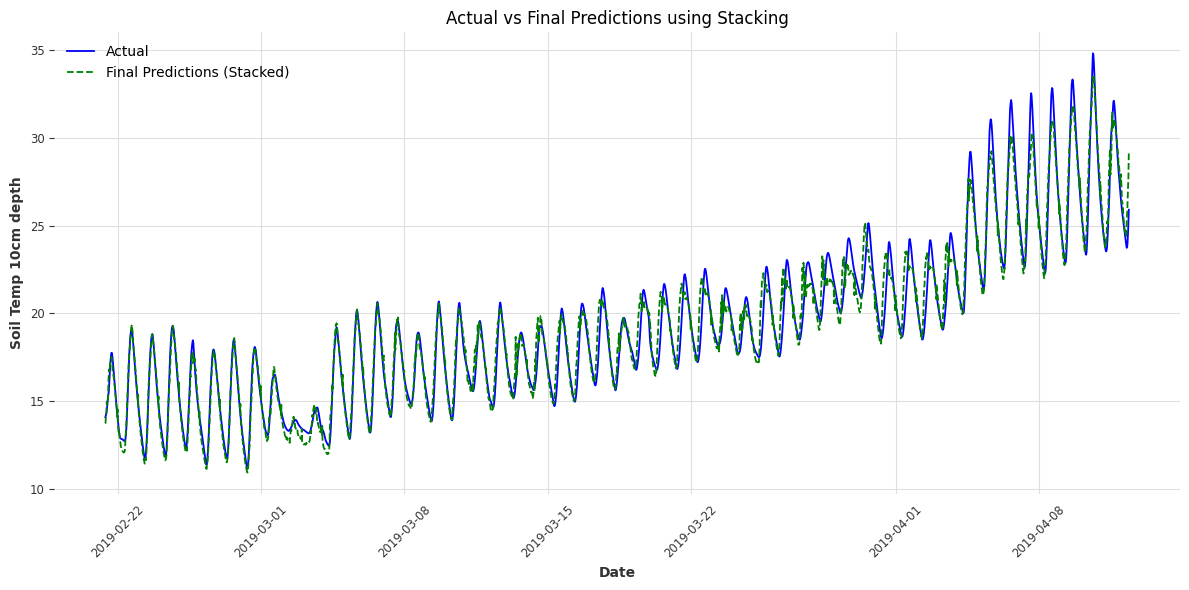

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(val_df.index, y_val, label='Actual', color='blue')
plt.plot(val_df.index, final_predictions, label='Final Predictions (Stacked)', color='green', linestyle='--')
plt.title('Actual vs Final Predictions using Stacking')
plt.xlabel('Date')
plt.ylabel('Soil Temp 10cm depth')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Get TCN predictions on the test set
tcn_predictions_test = tcn_model.predict(n=len(y_test), series=test_series_tcn[target])
tcn_predictions_np_test = tcn_predictions_test.values()

# Stack predictions for meta-model on test set
stack_X_test = np.column_stack((ann_test_predictions, tcn_predictions_np_test.flatten()))
stack_y_test = y_test  # Actual target values for test set

# Train a simple linear regression model on the stacked predictions (test set)
meta_model_test = LinearRegression()
meta_model_test.fit(stack_X_test, stack_y_test)

# Predict using the meta-model on test set
final_predictions_test = meta_model_test.predict(stack_X_test)

# Calculate R-squared for test set
r2_test = r2_score(stack_y_test, final_predictions_test)

# Calculate Median Absolute Deviation (MAD)
mad_test = np.median(np.abs(stack_y_test - final_predictions_test))

# Function to calculate Weighted Absolute Percentage Error (WAPE)
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Calculate WAPE for test set
wape_test = weighted_absolute_percentage_error(stack_y_test, final_predictions_test)

# Print the metrics: R², MAD, WAPE
print(f'Test R-squared (R²): {r2_test:.4f}')
print(f'Test Median Absolute Deviation (MAD): {mad_test:.4f}')
print(f'Test Weighted Absolute Percentage Error (WAPE): {wape_test:.4f}')


Predicting: |          | 0/? [00:00<?, ?it/s]

Test R-squared (R²): 0.9209
Test Median Absolute Deviation (MAD): 0.4907
Test Weighted Absolute Percentage Error (WAPE): 0.0254


In [7]:

def load_test_data(test_file):
    test_df = pd.read_csv(test_file)
    test_df['DateTime'] = pd.to_datetime(test_df['DateTime'], format="%d-%m-%Y %H:%M")  # Specify the correct format
    test_df.set_index('DateTime', inplace=True)
    return test_df
test_df = '/kaggle/input/dataset/test_transformed_10.csv'
test_df = load_test_data(test_df) 
# Prepare TimeSeries objects
train_series = TimeSeries.from_dataframe(train_df[features + [target]], freq='10T')
val_series = TimeSeries.from_dataframe(val_df[features + [target]], freq='10T')
test_series = TimeSeries.from_dataframe(test_df[features + [target]], freq='10T')


/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


Predicting: |          | 0/? [00:00<?, ?it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final Future Predictions Range: 17.194658148668346 35.018770164685996


/tmp/ipykernel_30/3901496187.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(last_date + pd.Timedelta(minutes=10), periods=n_future_steps, freq='10T')


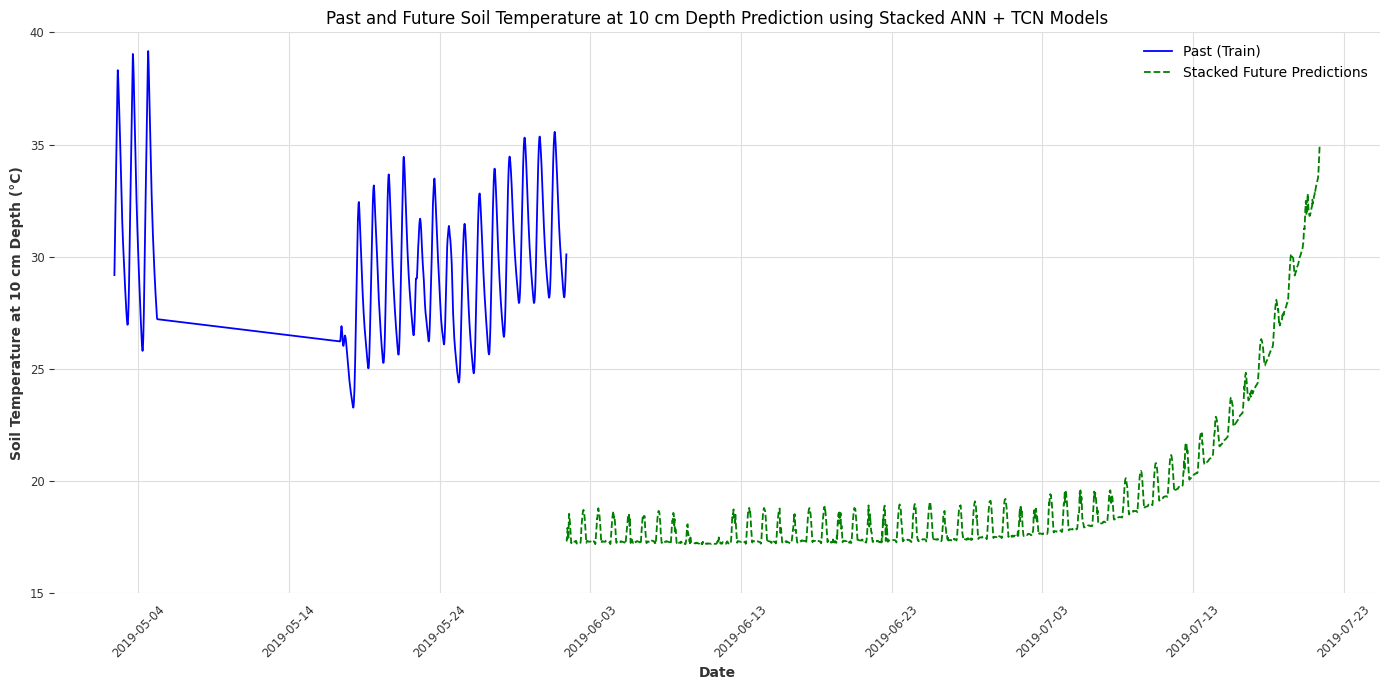

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

# Ensure the 'DateTime' column in train_df is a DateTimeIndex
if not isinstance(train_df.index, pd.DatetimeIndex):
    train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
    train_df.set_index('DateTime', inplace=True)

# Define the number of past observations to plot
n_past = 144 * 30  # Last 30 days of data
n_future_steps = 144 * 50  # Future predictions for 45 days

# Get TCN predictions for future steps (next n_future_steps)
tcn_predictions = tcn_model.predict(n=n_future_steps, series=test_series[target])
tcn_predictions_np = tcn_predictions.values()

# Get ANN predictions for future steps (ensure correct shape)
future_ann_predictions = ann_model.predict(X_val[:n_future_steps]).flatten()  # Use same input structure

# Create a stacked dataset for training the meta-model
stacked_X = np.column_stack((future_ann_predictions, tcn_predictions_np.flatten()))
stacked_y = y_val[:n_future_steps]  # Use actual target values for training

# Train the meta-model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_X, stacked_y)

# Make predictions using the meta-model for future data
final_future_predictions = meta_model.predict(stacked_X)

# Generate future time index based on the last datetime in train_df
last_date = test_df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(minutes=10), periods=n_future_steps, freq='10T')

# Check predictions range
print("Final Future Predictions Range:", final_future_predictions.min(), final_future_predictions.max())

# Plot past values (from training set) in blue and combined future predictions in green
plt.figure(figsize=(14, 7))

# Plot past values from training set
plt.plot(test_df.index[-n_past:], test_df[target][-n_past:], color='blue', label='Past (Train)')

# Plot combined future predictions
plt.plot(future_dates, final_future_predictions, label='Stacked Future Predictions', color='green', linestyle='--')

plt.title('Past and Future Soil Temperature at 10 cm Depth Prediction using Stacked ANN + TCN Models')
plt.xlabel('Date')
plt.ylabel('Soil Temperature at 10 cm Depth (°C)')

# Set legend location to the top right corner
plt.legend(loc='upper right')

# Format the x-axis to show the date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Adjust x-axis ticks and limits
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Tick every day
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
plt.xticks(rotation=45)

# Set y-axis limits based on expected temperature range (adjust if necessary)
plt.ylim(15, 40)  # Adjust this range based on your data

plt.tight_layout()
plt.show()

In [23]:
import pandas as pd
import joblib
# Save the trained meta-model
model_filename = 'model10Soil.pkl'  # Specify the filename
joblib.dump(meta_model, model_filename)
print(f'Meta-model saved to {model_filename}')
# Create a DataFrame for future predictions
future_results = pd.DataFrame({
    'DateTime': future_dates,
    'SoilTemp_10cm': final_future_predictions
})

# Specify the file name for saving
output_file = 'future_SoilTemp_10cm.xlsx'

# Save the DataFrame to an Excel file
future_results.to_excel(output_file, index=False)

print(f"Future forecasting results saved to {output_file}")

Meta-model saved to model10Soil.pkl
Future forecasting results saved to future_SoilTemp_10cm.xlsx


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from darts import TimeSeries
from darts.models import TCNModel

# Function to load data
def load_data(train_file, val_file):
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    
    # Convert 'DateTime' column to datetime and set as index
    for df in [train_df, val_df]:
        df['DateTime'] = pd.to_datetime(df['DateTime'], format="%d-%m-%Y %H:%M")  # Specify the correct format
        df.set_index('DateTime', inplace=True)
    
    return train_df, val_df

# Load CSV data files (adjust paths as needed)
train_file = '/kaggle/input/dataset/train_transformed_10 (1).csv'
val_file = '/kaggle/input/dataset/val_transformed_10.csv'
train_df, val_df = load_data(train_file, val_file)

# Select features and target
features = ['Month', 'Hour','SoilTemp_40cm', 'NET_Radiation', 'SoilTemp_10cm','SoilTemp_80cm']
target = 'SoilTemp_20cm'

X_train = train_df[features].values
y_train = train_df[target].values
X_val = val_df[features].values
y_val = val_df[target].values

# Normalize the data for ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Build and train ANN model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='linear'))  # Output for regression
ann_model.compile(optimizer='adam', loss='mse')
ann_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=32, verbose=1)

# Get ANN predictions for the training and validation sets
ann_train_predictions = ann_model.predict(X_train_scaled).flatten()
ann_val_predictions = ann_model.predict(X_val_scaled).flatten()

# Prepare TimeSeries objects for TCN including ANN predictions
train_df['ANN_Predictions'] = ann_train_predictions
val_df['ANN_Predictions'] = ann_val_predictions

train_series_tcn = TimeSeries.from_dataframe(train_df[features + [target, 'ANN_Predictions']], freq='10T')
val_series_tcn = TimeSeries.from_dataframe(val_df[features + [target, 'ANN_Predictions']], freq='10T')

# Initialize and train TCN model with ANN predictions as input
tcn_model = TCNModel(
    input_chunk_length=60,
    output_chunk_length=1,
    n_epochs=50,
    dropout=0.05,
    dilation_base=3,
    weight_norm=True,
    kernel_size=5,
    num_filters=16,
    random_state=0
)

# Fit the TCN model using the training series with ANN predictions
tcn_model.fit(series=train_series_tcn[target], val_series=val_series_tcn[target], verbose=True)

# Get TCN predictions
tcn_predictions = tcn_model.predict(n=len(y_val), series=train_series_tcn[target])
tcn_predictions_np = tcn_predictions.values()

# Stack predictions
stack_X = np.column_stack((ann_val_predictions, tcn_predictions_np.flatten()))
stack_y = y_val  # Actual target values

# Train a simple linear regression model on the stacked predictions
meta_model = LinearRegression()
meta_model.fit(stack_X, stack_y)

# Predict using the meta-model
final_predictions = meta_model.predict(stack_X)



Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 135.8948 - val_loss: 32.9759
Epoch 2/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1391 - val_loss: 6.6470
Epoch 3/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2562 - val_loss: 1.0510
Epoch 4/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0734 - val_loss: 0.4550
Epoch 5/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0428 - val_loss: 0.4018
Epoch 6/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0305 - val_loss: 0.4103
Epoch 7/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0282 - val_loss: 0.4606
Epoch 8/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0264 - val_loss: 0.5254
Epoch 9/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0237 - val_loss: 0.5784
Epoch 10/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0211 - val_loss: 0.5599
Epoch 11/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0200 - val_loss: 0.5581
Epoch 12/100
1051/1051 ━━━━━

/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Function to calculate Weighted Absolute Percentage Error (WAPE)
# Function to calculate Weighted Absolute Percentage Error (WAPE)
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Calculate WAPE
wape = weighted_absolute_percentage_error(y_val, final_predictions)

# MAD Calculation (Median Absolute Deviation)
mad = np.median(np.abs(y_val - final_predictions))
r2 = r2_score(stack_y, final_predictions)

# Print R-squared value
print(f'R-squared (R²) for Final Predictions: {r2:.4f}')

print(f'Median Absolute Deviation (MAD): {mad:.4f}')

print(f'Weighted Absolute Percentage Error (WAPE): {wape:.4f}') 



R-squared (R²) for Final Predictions: 0.9937
Median Absolute Deviation (MAD): 0.1945
Weighted Absolute Percentage Error (WAPE): 0.0127


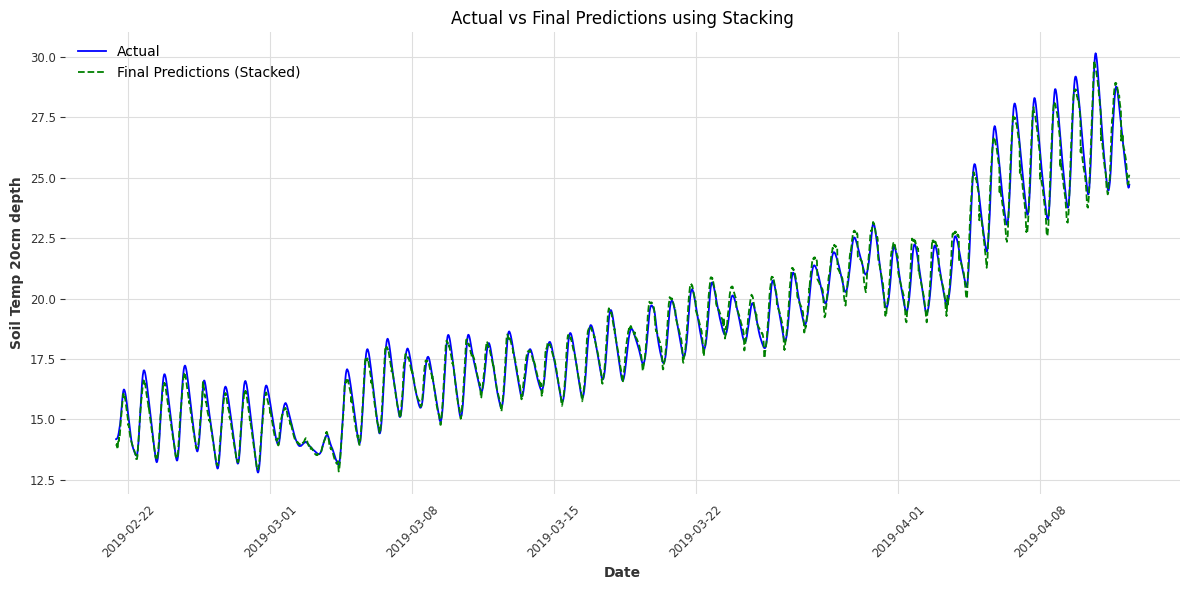

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(val_df.index, y_val, label='Actual', color='blue')
plt.plot(val_df.index, final_predictions, label='Final Predictions (Stacked)', color='green', linestyle='--')
plt.title('Actual vs Final Predictions using Stacking')
plt.xlabel('Date')
plt.ylabel('Soil Temp 20cm depth')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Get TCN predictions on the test set
tcn_predictions_test = tcn_model.predict(n=len(y_test), series=test_series_tcn[target])
tcn_predictions_np_test = tcn_predictions_test.values()

# Stack predictions for meta-model on test set
stack_X_test = np.column_stack((ann_test_predictions, tcn_predictions_np_test.flatten()))
stack_y_test = y_test  # Actual target values for test set

# Train a simple linear regression model on the stacked predictions (test set)
meta_model_test = LinearRegression()
meta_model_test.fit(stack_X_test, stack_y_test)

# Predict using the meta-model on test set
final_predictions_test = meta_model_test.predict(stack_X_test)

# Calculate R-squared for test set
r2_test = r2_score(stack_y_test, final_predictions_test)

# Calculate Median Absolute Deviation (MAD)
mad_test = np.median(np.abs(stack_y_test - final_predictions_test))

# Function to calculate Weighted Absolute Percentage Error (WAPE)
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Calculate WAPE for test set
wape_test = weighted_absolute_percentage_error(stack_y_test, final_predictions_test)

# Print the metrics: R², MAD, WAPE
print(f'Test R-squared (R²): {r2_test:.4f}')
print(f'Test Median Absolute Deviation (MAD): {mad_test:.4f}')
print(f'Test Weighted Absolute Percentage Error (WAPE): {wape_test:.4f}')


Predicting: |          | 0/? [00:00<?, ?it/s]

Test R-squared (R²): 0.9194
Test Median Absolute Deviation (MAD): 0.4844
Test Weighted Absolute Percentage Error (WAPE): 0.0255


In [28]:

def load_test_data(test_file):
    test_df = pd.read_csv(test_file)
    test_df['DateTime'] = pd.to_datetime(test_df['DateTime'], format="%d-%m-%Y %H:%M")  # Specify the correct format
    test_df.set_index('DateTime', inplace=True)
    return test_df
test_df = '/kaggle/input/dataset/test_transformed_10.csv'
test_df = load_test_data(test_df) 
# Prepare TimeSeries objects
train_series = TimeSeries.from_dataframe(train_df[features + [target]], freq='10T')
val_series = TimeSeries.from_dataframe(val_df[features + [target]], freq='10T')
test_series = TimeSeries.from_dataframe(test_df[features + [target]], freq='10T')


/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


Predicting: |          | 0/? [00:00<?, ?it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final Future Predictions Range: 18.06458655064693 34.87937240052536


/tmp/ipykernel_30/1541980623.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(last_date + pd.Timedelta(minutes=10), periods=n_future_steps, freq='10T')


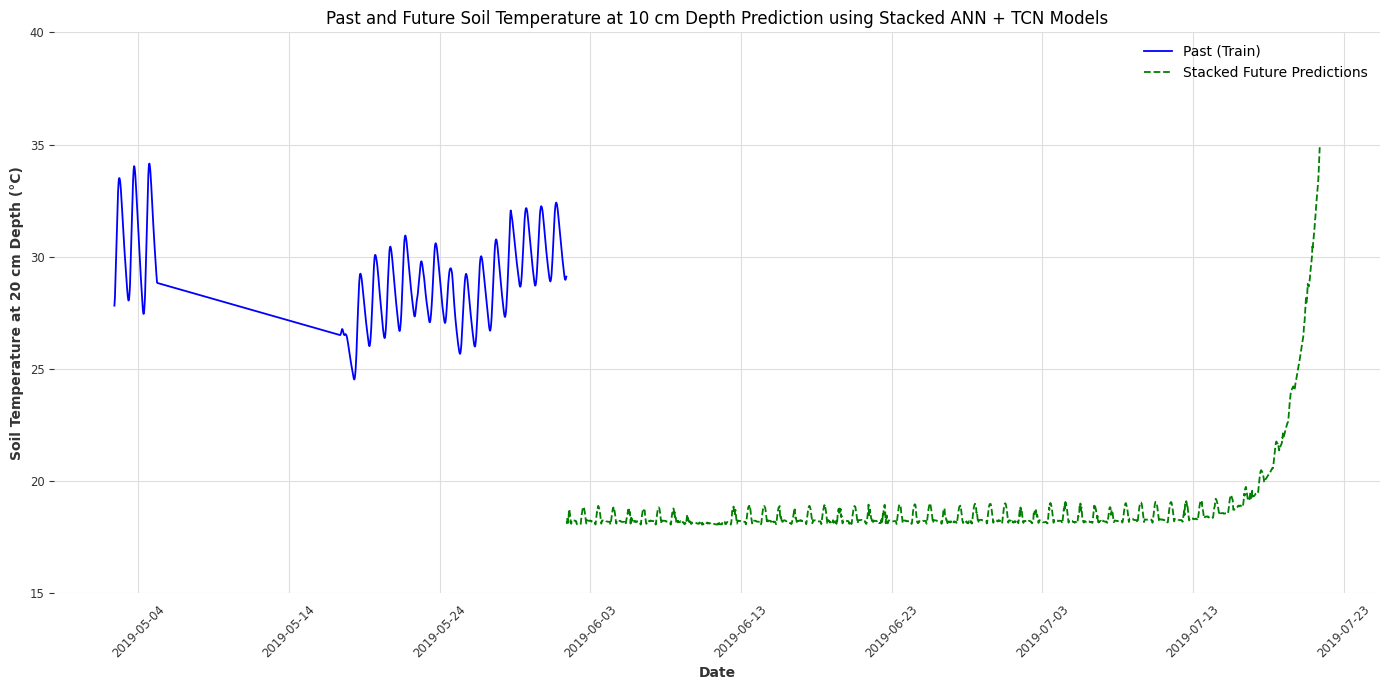

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

# Ensure the 'DateTime' column in train_df is a DateTimeIndex
if not isinstance(train_df.index, pd.DatetimeIndex):
    train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
    train_df.set_index('DateTime', inplace=True)

# Define the number of past observations to plot
n_past = 144 * 30  # Last 30 days of data
n_future_steps = 144 * 50  # Future predictions for 45 days

# Get TCN predictions for future steps (next n_future_steps)
tcn_predictions = tcn_model.predict(n=n_future_steps, series=test_series[target])
tcn_predictions_np = tcn_predictions.values()

# Get ANN predictions for future steps (ensure correct shape)
future_ann_predictions = ann_model.predict(X_val[:n_future_steps]).flatten()  # Use same input structure

# Create a stacked dataset for training the meta-model
stacked_X = np.column_stack((future_ann_predictions, tcn_predictions_np.flatten()))
stacked_y = y_val[:n_future_steps]  # Use actual target values for training

# Train the meta-model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_X, stacked_y)

# Make predictions using the meta-model for future data
final_future_predictions = meta_model.predict(stacked_X)

# Generate future time index based on the last datetime in train_df
last_date = test_df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(minutes=10), periods=n_future_steps, freq='10T')

# Check predictions range
print("Final Future Predictions Range:", final_future_predictions.min(), final_future_predictions.max())

# Plot past values (from training set) in blue and combined future predictions in green
plt.figure(figsize=(14, 7))

# Plot past values from training set
plt.plot(test_df.index[-n_past:], test_df[target][-n_past:], color='blue', label='Past (Train)')

# Plot combined future predictions
plt.plot(future_dates, final_future_predictions, label='Stacked Future Predictions', color='green', linestyle='--')

plt.title('Past and Future Soil Temperature at 10 cm Depth Prediction using Stacked ANN + TCN Models')
plt.xlabel('Date')
plt.ylabel('Soil Temperature at 20 cm Depth (°C)')

# Set legend location to the top right corner
plt.legend(loc='upper right')

# Format the x-axis to show the date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Adjust x-axis ticks and limits
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Tick every day
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
plt.xticks(rotation=45)

# Set y-axis limits based on expected temperature range (adjust if necessary)
plt.ylim(15, 40)  # Adjust this range based on your data

plt.tight_layout()
plt.show()

In [32]:
import pandas as pd
import joblib
# Save the trained meta-model
model_filename = 'model20Soil.pkl'  # Specify the filename
joblib.dump(meta_model, model_filename)
print(f'Meta-model saved to {model_filename}')
# Create a DataFrame for future predictions
future_results = pd.DataFrame({
    'DateTime': future_dates,
    'SoilTemp_20cm': final_future_predictions
})

# Specify the file name for saving
output_file = 'future_SoilTemp_20cm.xlsx'

# Save the DataFrame to an Excel file
future_results.to_excel(output_file, index=False)

print(f"Future forecasting results saved to {output_file}")

Meta-model saved to model20Soil.pkl
Future forecasting results saved to future_SoilTemp_20cm.xlsx


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from darts import TimeSeries
from darts.models import TCNModel

# Function to load data
def load_data(train_file, val_file):
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    
    # Convert 'DateTime' column to datetime and set as index
    for df in [train_df, val_df]:
        df['DateTime'] = pd.to_datetime(df['DateTime'], format="%d-%m-%Y %H:%M")  # Specify the correct format
        df.set_index('DateTime', inplace=True)
    
    return train_df, val_df

# Load CSV data files (adjust paths as needed)
train_file = '/kaggle/input/dataset/train_transformed_10 (1).csv'
val_file = '/kaggle/input/dataset/val_transformed_10.csv'
train_df, val_df = load_data(train_file, val_file)

# Select features and target
features = ['Month', 'Hour','SoilTemp_20cm', 'NET_Radiation', 'SoilTemp_10cm','SoilTemp_80cm']
target = 'SoilTemp_40cm'

X_train = train_df[features].values
y_train = train_df[target].values
X_val = val_df[features].values
y_val = val_df[target].values

# Normalize the data for ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Build and train ANN model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='linear'))  # Output for regression
ann_model.compile(optimizer='adam', loss='mse')
ann_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=32, verbose=1)

# Get ANN predictions for the training and validation sets
ann_train_predictions = ann_model.predict(X_train_scaled).flatten()
ann_val_predictions = ann_model.predict(X_val_scaled).flatten()

# Prepare TimeSeries objects for TCN including ANN predictions
train_df['ANN_Predictions'] = ann_train_predictions
val_df['ANN_Predictions'] = ann_val_predictions

train_series_tcn = TimeSeries.from_dataframe(train_df[features + [target, 'ANN_Predictions']], freq='10T')
val_series_tcn = TimeSeries.from_dataframe(val_df[features + [target, 'ANN_Predictions']], freq='10T')

# Initialize and train TCN model with ANN predictions as input
tcn_model = TCNModel(
    input_chunk_length=60,
    output_chunk_length=1,
    n_epochs=50,
    dropout=0.05,
    dilation_base=3,
    weight_norm=True,
    kernel_size=5,
    num_filters=16,
    random_state=0
)

# Fit the TCN model using the training series with ANN predictions
tcn_model.fit(series=train_series_tcn[target], val_series=val_series_tcn[target], verbose=True)

# Get TCN predictions
tcn_predictions = tcn_model.predict(n=len(y_val), series=train_series_tcn[target])
tcn_predictions_np = tcn_predictions.values()

# Stack predictions
stack_X = np.column_stack((ann_val_predictions, tcn_predictions_np.flatten()))
stack_y = y_val  # Actual target values

# Train a simple linear regression model on the stacked predictions
meta_model = LinearRegression()
meta_model.fit(stack_X, stack_y)

# Predict using the meta-model
final_predictions = meta_model.predict(stack_X)



Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 163.4636 - val_loss: 32.2599
Epoch 2/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1399 - val_loss: 12.4304
Epoch 3/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2485 - val_loss: 3.5044
Epoch 4/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1088 - val_loss: 2.0318
Epoch 5/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0613 - val_loss: 1.0604
Epoch 6/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0412 - val_loss: 0.8541
Epoch 7/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0337 - val_loss: 0.6753
Epoch 8/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0250 - val_loss: 0.5553
Epoch 9/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0224 - val_loss: 0.4257
Epoch 10/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0224 - val_loss: 0.4045
Epoch 11/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0196 - val_loss: 0.4051
Epoch 12/100
1051/1051 ━━━━

/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Function to calculate Weighted Absolute Percentage Error (WAPE)
# Function to calculate Weighted Absolute Percentage Error (WAPE)
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Calculate WAPE
wape = weighted_absolute_percentage_error(y_val, final_predictions)

# MAD Calculation (Median Absolute Deviation)
mad = np.median(np.abs(y_val - final_predictions))
r2 = r2_score(stack_y, final_predictions)

# Print R-squared value
print(f'R-squared (R²) for Final Predictions: {r2:.4f}')

print(f'Median Absolute Deviation (MAD): {mad:.4f}')

print(f'Weighted Absolute Percentage Error (WAPE): {wape:.4f}') 



R-squared (R²) for Final Predictions: 0.9932
Median Absolute Deviation (MAD): 0.1548
Weighted Absolute Percentage Error (WAPE): 0.0106


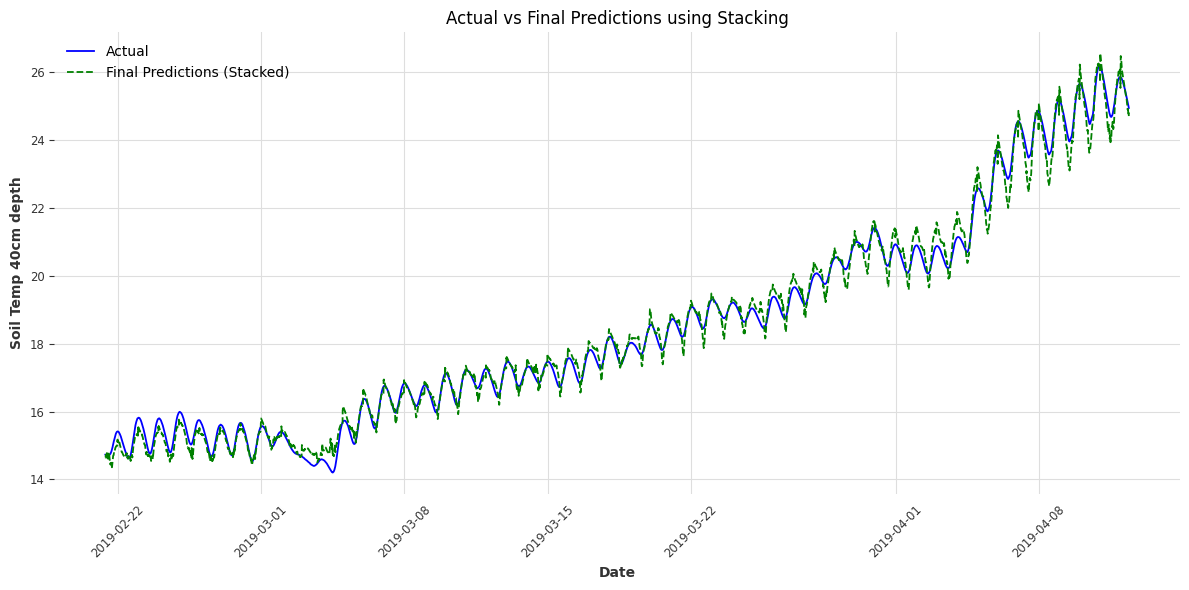

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(val_df.index, y_val, label='Actual', color='blue')
plt.plot(val_df.index, final_predictions, label='Final Predictions (Stacked)', color='green', linestyle='--')
plt.title('Actual vs Final Predictions using Stacking')
plt.xlabel('Date')
plt.ylabel('Soil Temp 40cm depth')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Get TCN predictions on the test set
tcn_predictions_test = tcn_model.predict(n=len(y_test), series=test_series_tcn[target])
tcn_predictions_np_test = tcn_predictions_test.values()

# Stack predictions for meta-model on test set
stack_X_test = np.column_stack((ann_test_predictions, tcn_predictions_np_test.flatten()))
stack_y_test = y_test  # Actual target values for test set

# Train a simple linear regression model on the stacked predictions (test set)
meta_model_test = LinearRegression()
meta_model_test.fit(stack_X_test, stack_y_test)

# Predict using the meta-model on test set
final_predictions_test = meta_model_test.predict(stack_X_test)

# Calculate R-squared for test set
r2_test = r2_score(stack_y_test, final_predictions_test)

# Calculate Median Absolute Deviation (MAD)
mad_test = np.median(np.abs(stack_y_test - final_predictions_test))

# Function to calculate Weighted Absolute Percentage Error (WAPE)
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Calculate WAPE for test set
wape_test = weighted_absolute_percentage_error(stack_y_test, final_predictions_test)

# Print the metrics: R², MAD, WAPE
print(f'Test R-squared (R²): {r2_test:.4f}')
print(f'Test Median Absolute Deviation (MAD): {mad_test:.4f}')
print(f'Test Weighted Absolute Percentage Error (WAPE): {wape_test:.4f}')


Predicting: |          | 0/? [00:00<?, ?it/s]

Test R-squared (R²): 0.9247
Test Median Absolute Deviation (MAD): 0.4554
Test Weighted Absolute Percentage Error (WAPE): 0.0241


In [39]:

def load_test_data(test_file):
    test_df = pd.read_csv(test_file)
    test_df['DateTime'] = pd.to_datetime(test_df['DateTime'], format="%d-%m-%Y %H:%M")  # Specify the correct format
    test_df.set_index('DateTime', inplace=True)
    return test_df
test_df = '/kaggle/input/dataset/test_transformed_10.csv'
test_df = load_test_data(test_df) 
# Prepare TimeSeries objects
train_series = TimeSeries.from_dataframe(train_df[features + [target]], freq='10T')
val_series = TimeSeries.from_dataframe(val_df[features + [target]], freq='10T')
test_series = TimeSeries.from_dataframe(test_df[features + [target]], freq='10T')


/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


Predicting: |          | 0/? [00:00<?, ?it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final Future Predictions Range: 14.935912427410788 22.37720076387097


/tmp/ipykernel_30/667070221.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(last_date + pd.Timedelta(minutes=10), periods=n_future_steps, freq='10T')


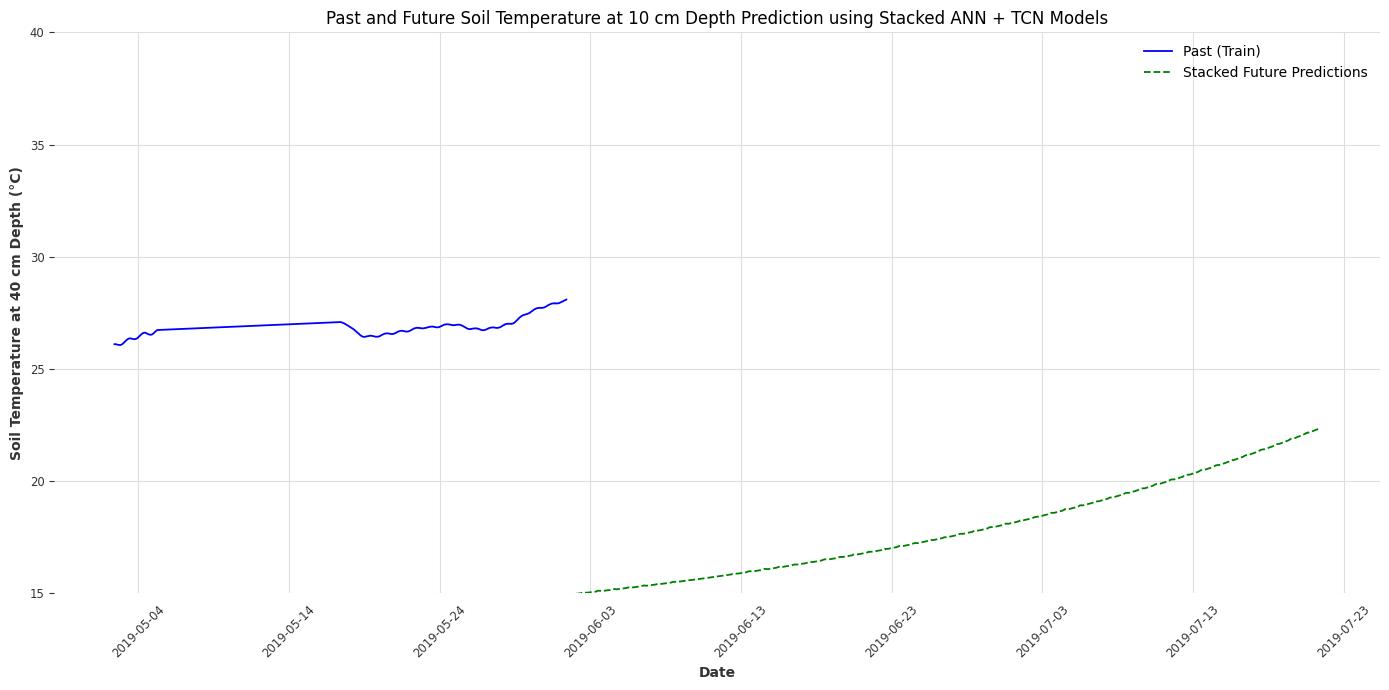

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

# Ensure the 'DateTime' column in train_df is a DateTimeIndex
if not isinstance(train_df.index, pd.DatetimeIndex):
    train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
    train_df.set_index('DateTime', inplace=True)

# Define the number of past observations to plot
n_past = 144 * 30  # Last 30 days of data
n_future_steps = 144 * 50  # Future predictions for 45 days

# Get TCN predictions for future steps (next n_future_steps)
tcn_predictions = tcn_model.predict(n=n_future_steps, series=test_series[target])
tcn_predictions_np = tcn_predictions.values()

# Get ANN predictions for future steps (ensure correct shape)
future_ann_predictions = ann_model.predict(X_val[:n_future_steps]).flatten()  # Use same input structure

# Create a stacked dataset for training the meta-model
stacked_X = np.column_stack((future_ann_predictions, tcn_predictions_np.flatten()))
stacked_y = y_val[:n_future_steps]  # Use actual target values for training

# Train the meta-model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_X, stacked_y)

# Make predictions using the meta-model for future data
final_future_predictions = meta_model.predict(stacked_X)

# Generate future time index based on the last datetime in train_df
last_date = test_df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(minutes=10), periods=n_future_steps, freq='10T')

# Check predictions range
print("Final Future Predictions Range:", final_future_predictions.min(), final_future_predictions.max())

# Plot past values (from training set) in blue and combined future predictions in green
plt.figure(figsize=(14, 7))

# Plot past values from training set
plt.plot(test_df.index[-n_past:], test_df[target][-n_past:], color='blue', label='Past (Train)')

# Plot combined future predictions
plt.plot(future_dates, final_future_predictions, label='Stacked Future Predictions', color='green', linestyle='--')

plt.title('Past and Future Soil Temperature at 10 cm Depth Prediction using Stacked ANN + TCN Models')
plt.xlabel('Date')
plt.ylabel('Soil Temperature at 40 cm Depth (°C)')

# Set legend location to the top right corner
plt.legend(loc='upper right')

# Format the x-axis to show the date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Adjust x-axis ticks and limits
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Tick every day
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
plt.xticks(rotation=45)

# Set y-axis limits based on expected temperature range (adjust if necessary)
plt.ylim(15, 40)  # Adjust this range based on your data

plt.tight_layout()
plt.show()

In [41]:
import pandas as pd
import joblib
# Save the trained meta-model
model_filename = 'model40Soil.pkl'  # Specify the filename
joblib.dump(meta_model, model_filename)
print(f'Meta-model saved to {model_filename}')
# Create a DataFrame for future predictions
future_results = pd.DataFrame({
    'DateTime': future_dates,
    'SoilTemp_40cm': final_future_predictions
})

# Specify the file name for saving
output_file = 'future_SoilTemp_40cm.xlsx'

# Save the DataFrame to an Excel file
future_results.to_excel(output_file, index=False)

print(f"Future forecasting results saved to {output_file}")

Meta-model saved to model40Soil.pkl
Future forecasting results saved to future_SoilTemp_40cm.xlsx


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from darts import TimeSeries
from darts.models import TCNModel

# Function to load data
def load_data(train_file, val_file):
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    
    # Convert 'DateTime' column to datetime and set as index
    for df in [train_df, val_df]:
        df['DateTime'] = pd.to_datetime(df['DateTime'], format="%d-%m-%Y %H:%M")  # Specify the correct format
        df.set_index('DateTime', inplace=True)
    
    return train_df, val_df

# Load CSV data files (adjust paths as needed)
train_file = '/kaggle/input/dataset/train_transformed_10 (1).csv'
val_file = '/kaggle/input/dataset/val_transformed_10.csv'
train_df, val_df = load_data(train_file, val_file)

# Select features and target
features = ['Month', 'Hour','SoilTemp_20cm', 'NET_Radiation', 'SoilTemp_10cm','SoilTemp_40cm']
target = 'SoilTemp_80cm'

X_train = train_df[features].values
y_train = train_df[target].values
X_val = val_df[features].values
y_val = val_df[target].values

# Normalize the data for ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Build and train ANN model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='linear'))  # Output for regression
ann_model.compile(optimizer='adam', loss='mse')
ann_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=32, verbose=1)

# Get ANN predictions for the training and validation sets
ann_train_predictions = ann_model.predict(X_train_scaled).flatten()
ann_val_predictions = ann_model.predict(X_val_scaled).flatten()

# Prepare TimeSeries objects for TCN including ANN predictions
train_df['ANN_Predictions'] = ann_train_predictions
val_df['ANN_Predictions'] = ann_val_predictions

train_series_tcn = TimeSeries.from_dataframe(train_df[features + [target, 'ANN_Predictions']], freq='10T')
val_series_tcn = TimeSeries.from_dataframe(val_df[features + [target, 'ANN_Predictions']], freq='10T')

# Initialize and train TCN model with ANN predictions as input
tcn_model = TCNModel(
    input_chunk_length=60,
    output_chunk_length=1,
    n_epochs=50,
    dropout=0.05,
    dilation_base=3,
    weight_norm=True,
    kernel_size=5,
    num_filters=16,
    random_state=0
)

# Fit the TCN model using the training series with ANN predictions
tcn_model.fit(series=train_series_tcn[target], val_series=val_series_tcn[target], verbose=True)

# Get TCN predictions
tcn_predictions = tcn_model.predict(n=len(y_val), series=train_series_tcn[target])
tcn_predictions_np = tcn_predictions.values()

# Stack predictions
stack_X = np.column_stack((ann_val_predictions, tcn_predictions_np.flatten()))
stack_y = y_val  # Actual target values

# Train a simple linear regression model on the stacked predictions
meta_model = LinearRegression()
meta_model.fit(stack_X, stack_y)

# Predict using the meta-model
final_predictions = meta_model.predict(stack_X)



Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 160.6580 - val_loss: 12.7474
Epoch 2/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4046 - val_loss: 2.0441
Epoch 3/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2473 - val_loss: 1.8761
Epoch 4/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1264 - val_loss: 1.9736
Epoch 5/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0925 - val_loss: 2.0576
Epoch 6/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0762 - val_loss: 2.4607
Epoch 7/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0661 - val_loss: 2.1065
Epoch 8/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0571 - val_loss: 2.2839
Epoch 9/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0534 - val_loss: 2.3196
Epoch 10/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0509 - val_loss: 2.1288
Epoch 11/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0450 - val_loss: 2.4813
Epoch 12/100
1051/1051 ━━━━━

/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Function to calculate Weighted Absolute Percentage Error (WAPE)
# Function to calculate Weighted Absolute Percentage Error (WAPE)
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Calculate WAPE
wape = weighted_absolute_percentage_error(y_val, final_predictions)

# MAD Calculation (Median Absolute Deviation)
mad = np.median(np.abs(y_val - final_predictions))
r2 = r2_score(stack_y, final_predictions)

# Print R-squared value
print(f'R-squared (R²) for Final Predictions: {r2:.4f}')

print(f'Median Absolute Deviation (MAD): {mad:.4f}')

print(f'Weighted Absolute Percentage Error (WAPE): {wape:.4f}') 



R-squared (R²) for Final Predictions: 0.9832
Median Absolute Deviation (MAD): 0.1821
Weighted Absolute Percentage Error (WAPE): 0.0119


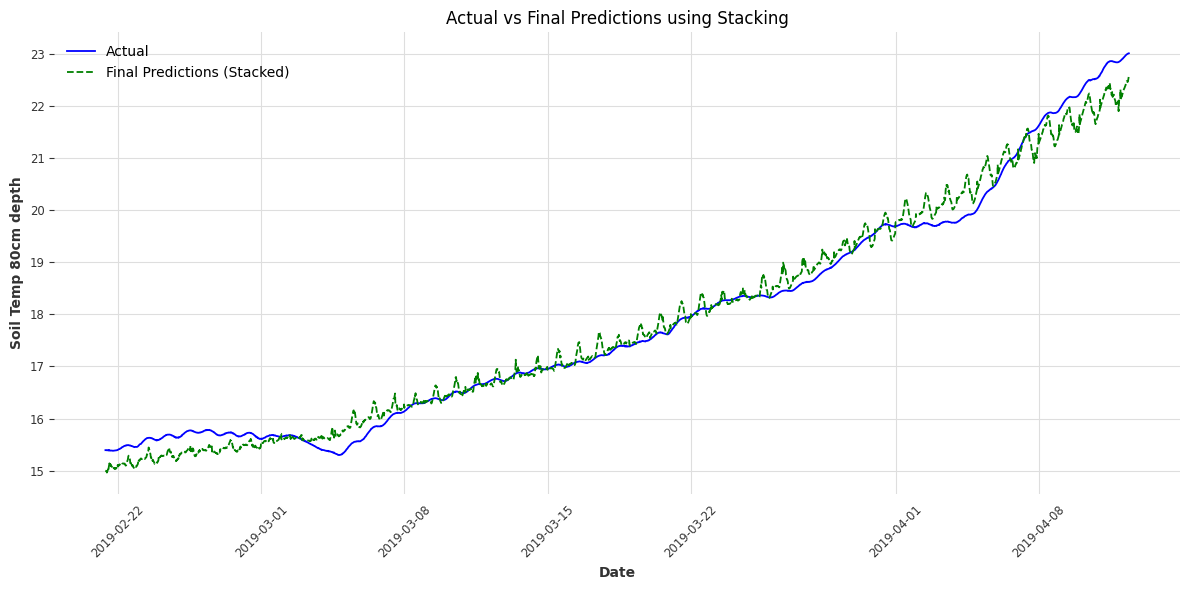

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(val_df.index, y_val, label='Actual', color='blue')
plt.plot(val_df.index, final_predictions, label='Final Predictions (Stacked)', color='green', linestyle='--')
plt.title('Actual vs Final Predictions using Stacking')
plt.xlabel('Date')
plt.ylabel('Soil Temp 80cm depth')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# Get TCN predictions on the test set
tcn_predictions_test = tcn_model.predict(n=len(y_test), series=test_series_tcn[target])
tcn_predictions_np_test = tcn_predictions_test.values()

# Stack predictions for meta-model on test set
stack_X_test = np.column_stack((ann_test_predictions, tcn_predictions_np_test.flatten()))
stack_y_test = y_test  # Actual target values for test set

# Train a simple linear regression model on the stacked predictions (test set)
meta_model_test = LinearRegression()
meta_model_test.fit(stack_X_test, stack_y_test)

# Predict using the meta-model on test set
final_predictions_test = meta_model_test.predict(stack_X_test)

# Calculate R-squared for test set
r2_test = r2_score(stack_y_test, final_predictions_test)

# Calculate Median Absolute Deviation (MAD)
mad_test = np.median(np.abs(stack_y_test - final_predictions_test))

# Function to calculate Weighted Absolute Percentage Error (WAPE)
def weighted_absolute_percentage_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Calculate WAPE for test set
wape_test = weighted_absolute_percentage_error(stack_y_test, final_predictions_test)

# Print the metrics: R², MAD, WAPE
print(f'Test R-squared (R²): {r2_test:.4f}')
print(f'Test Median Absolute Deviation (MAD): {mad_test:.4f}')
print(f'Test Weighted Absolute Percentage Error (WAPE): {wape_test:.4f}')


Predicting: |          | 0/? [00:00<?, ?it/s]

Test R-squared (R²): 0.9247
Test Median Absolute Deviation (MAD): 0.4558
Test Weighted Absolute Percentage Error (WAPE): 0.0241


In [47]:

def load_test_data(test_file):
    test_df = pd.read_csv(test_file)
    test_df['DateTime'] = pd.to_datetime(test_df['DateTime'], format="%d-%m-%Y %H:%M")  # Specify the correct format
    test_df.set_index('DateTime', inplace=True)
    return test_df
test_df = '/kaggle/input/dataset/test_transformed_10.csv'
test_df = load_test_data(test_df) 
# Prepare TimeSeries objects
train_series = TimeSeries.from_dataframe(train_df[features + [target]], freq='10T')
val_series = TimeSeries.from_dataframe(val_df[features + [target]], freq='10T')
test_series = TimeSeries.from_dataframe(test_df[features + [target]], freq='10T')


/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/opt/conda/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


Predicting: |          | 0/? [00:00<?, ?it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final Future Predictions Range: 14.935912427410788 22.37720076387097


/tmp/ipykernel_30/481105661.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(last_date + pd.Timedelta(minutes=10), periods=n_future_steps, freq='10T')


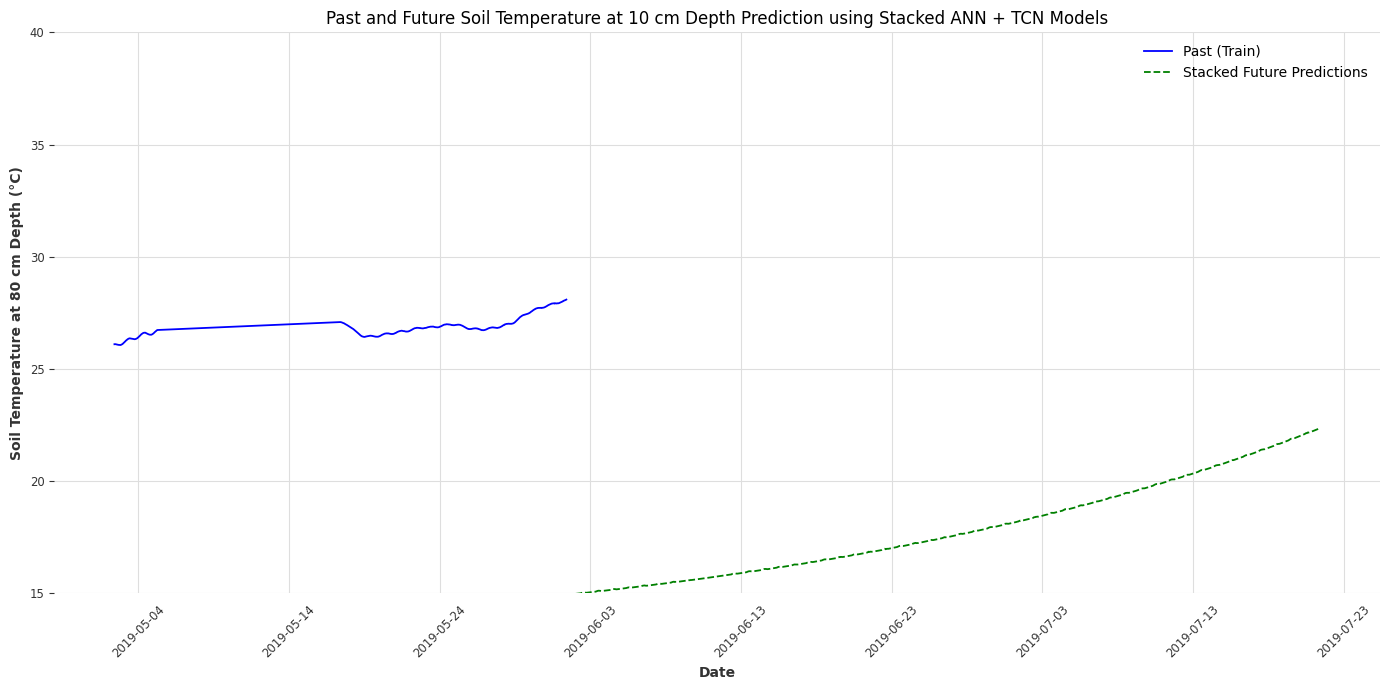

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

# Ensure the 'DateTime' column in train_df is a DateTimeIndex
if not isinstance(train_df.index, pd.DatetimeIndex):
    train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
    train_df.set_index('DateTime', inplace=True)

# Define the number of past observations to plot
n_past = 144 * 30  # Last 30 days of data
n_future_steps = 144 * 50  # Future predictions for 45 days

# Get TCN predictions for future steps (next n_future_steps)
tcn_predictions = tcn_model.predict(n=n_future_steps, series=test_series[target])
tcn_predictions_np = tcn_predictions.values()

# Get ANN predictions for future steps (ensure correct shape)
future_ann_predictions = ann_model.predict(X_val[:n_future_steps]).flatten()  # Use same input structure

# Create a stacked dataset for training the meta-model
stacked_X = np.column_stack((future_ann_predictions, tcn_predictions_np.flatten()))
stacked_y = y_val[:n_future_steps]  # Use actual target values for training

# Train the meta-model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_X, stacked_y)

# Make predictions using the meta-model for future data
final_future_predictions = meta_model.predict(stacked_X)

# Generate future time index based on the last datetime in train_df
last_date = test_df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(minutes=10), periods=n_future_steps, freq='10T')

# Check predictions range
print("Final Future Predictions Range:", final_future_predictions.min(), final_future_predictions.max())

# Plot past values (from training set) in blue and combined future predictions in green
plt.figure(figsize=(14, 7))

# Plot past values from training set
plt.plot(test_df.index[-n_past:], test_df[target][-n_past:], color='blue', label='Past (Train)')

# Plot combined future predictions
plt.plot(future_dates, final_future_predictions, label='Stacked Future Predictions', color='green', linestyle='--')

plt.title('Past and Future Soil Temperature at 10 cm Depth Prediction using Stacked ANN + TCN Models')
plt.xlabel('Date')
plt.ylabel('Soil Temperature at 80 cm Depth (°C)')

# Set legend location to the top right corner
plt.legend(loc='upper right')

# Format the x-axis to show the date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Adjust x-axis ticks and limits
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Tick every day
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
plt.xticks(rotation=45)

# Set y-axis limits based on expected temperature range (adjust if necessary)
plt.ylim(15, 40)  # Adjust this range based on your data

plt.tight_layout()
plt.show()

In [50]:
import pandas as pd
import joblib
# Save the trained meta-model
model_filename = 'model80Soil.pkl'  # Specify the filename
joblib.dump(meta_model, model_filename)
print(f'Meta-model saved to {model_filename}')
# Create a DataFrame for future predictions
future_results = pd.DataFrame({
    'DateTime': future_dates,
    'SoilTemp_80cm': final_future_predictions
})

# Specify the file name for saving
output_file = 'future_SoilTemp_80cm.xlsx'

# Save the DataFrame to an Excel file
future_results.to_excel(output_file, index=False)

print(f"Future forecasting results saved to {output_file}")

Meta-model saved to model80Soil.pkl
Future forecasting results saved to future_SoilTemp_80cm.xlsx
